In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import itertools

In [8]:
def preprocess_data(df):
    """Prepare data for modeling with feature selection and column standardization"""
    # Convert column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Define features we want to keep
    selected_features = [
        'amhtxrc3', 'illyr', 'bngdrkmon', 'hvydrkmon', 'snysell', 
        'snrlgsvc', 'snrlgimp', 'sexident', 'irsex', 'eduhighcat', 
        'health2', 'newrace2', 'catag3', 'wrkdpstyr', 'irwrkstat', 
        'income', 'poverty3', 'medicare', 'caidchip', 'champus'
    ]
    
    # Select only the features we want
    df = df[selected_features].copy()
    
    # Drop rows with invalid categories based on codebook
    df = df[df['snysell'].isin([1, 2, 3, 4, 5])]
    df = df[df['snrlgsvc'].isin([1, 2, 3, 4, 5, 6])]
    df = df[df['snrlgimp'].isin([1, 2, 3, 4])]
    df = df[df['sexident'].isin([1, 2, 3])]
    df = df[df['health2'].isin([1, 2, 3, 4])]
    df = df[df['irwrkstat'].isin([1, 2, 3])]
    df = df[df['medicare'].isin([1, 2])]
    df = df[df['caidchip'].isin([1, 2])]
    df = df[df['champus'].isin([1, 2])]
    
    # Drop any rows with null values
    df = df.dropna()
    
    # Recode target variable to binary
    df['amhtxrc3'] = df['amhtxrc3'].replace({2.0: 0, 1.0: 1})
    
    # Split features and target
    X = df.drop('amhtxrc3', axis=1)
    y = df['amhtxrc3']
    
    # Convert all features to category type
    for col in X.columns:
        X[col] = X[col].astype('category')
    
    return X, y

def create_pipeline():
    """Create pipeline with preprocessing and model"""
    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('encoder', OneHotEncoder(handle_unknown='ignore'), slice(None))
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=10))
    ])
    
    return pipeline

In [9]:
def perform_grid_search(pipeline, X_train, y_train):
    """Perform grid search for hyperparameter tuning"""
    # Define parameter grid
    param_grid = {
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__bootstrap': [True, False]
    }
    
    # Create grid search object
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Print best parameters and score
    print("\nBest parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    return grid_search

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred) * 100
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return y_pred, y_pred_proba, accuracy, roc_auc

def get_feature_importance(model, X):
    """Extract feature importance from the model"""
    # Get feature names from preprocessor
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    
    # Get feature importance scores
    importance = model.named_steps['classifier'].feature_importances_
    
    # Create and sort importance pairs
    importance_pairs = list(zip(feature_names, importance))
    return sorted(importance_pairs, key=lambda x: x[1], reverse=True)




In [10]:
def plot_cv_results(grid_search):
    """Plot cross-validation results"""
    results = pd.DataFrame(grid_search.cv_results_)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(results['param_classifier__n_estimators'], 
                results['mean_test_score'])
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean CV Score')
    
    plt.subplot(1, 2, 2)
    plt.scatter(results['param_classifier__min_samples_leaf'], 
                results['mean_test_score'])
    plt.xlabel('Min Samples Leaf')
    plt.ylabel('Mean CV Score')
    plt.show()

def plot_roc_curve(y_test, y_pred_proba):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'r', label='Model')
    plt.plot([0, 1], [0, 1], 'b--', label='Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_feature_importance(importance_sorted, top_n=15):
    """Plot top feature importance"""
    top_features = [i[0] for i in importance_sorted[:top_n]]
    importances = [i[1] for i in importance_sorted[:top_n]]
    
    plt.figure(figsize=(10, 14))
    plt.barh(top_features, importances)
    plt.title(f'Top {top_n} Important Features')
    plt.xlabel('Importance')
    plt.show()

In [11]:
# def main(input_file=None, test_size=0.3, cv_folds=5):
#     """Main execution function
    
#     Args:
#         input_file (str): Path to input CSV file
#         test_size (float): Proportion of data to use for testing
#         cv_folds (int): Number of cross-validation folds
#     """
#     # Load data if file provided
#     if input_file:
#         df = pd.read_csv(input_file)
#     else:
#         # Assume df1 is in memory
#         df = df1
#     # Preprocess data
#     X, y = preprocess_data(df)
    
#     # Split the data
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.3, random_state=10
#     )
    
#     # Create pipeline
#     pipeline = create_pipeline()
    
#     # Perform cross-validation before tuning
#     print("Performing initial cross-validation...")
#     cv_scores = cross_val_score(
#         pipeline, X_train, y_train, 
#         cv=5, scoring='roc_auc', n_jobs=-1
#     )
#     print(f"Initial CV Scores: {cv_scores}")
#     print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
#     # Perform grid search
#     print("\nPerforming grid search...")
#     grid_search = perform_grid_search(pipeline, X_train, y_train)
    
#     # Get best model
#     best_model = grid_search.best_estimator_
    
#     # Evaluate on test set
#     y_pred, y_pred_proba, accuracy, roc_auc = evaluate_model(
#         best_model, X_test, y_test
#     )
    
#     # Get feature importance
#     importance_sorted = get_feature_importance(best_model, X)
    
#     # Plot results
#     plot_cv_results(grid_search)
#     plot_roc_curve(y_test, y_pred_proba)
#     plot_feature_importance(importance_sorted)
    
#     # Print final results
#     print("\nFinal Model Performance:")
#     print(f"Test Set Accuracy: {accuracy:.2f}%")
#     print(f"Test Set ROC AUC: {roc_auc:.3f}")
    
#     return best_model, grid_search, importance_sorted


In [16]:
input_file='C:/Users/elote/Repositories/Statistics-and-Machine-Learning-Fall-2021/data/NSDUH_2015_2019.csv'

In [21]:
def main(input_file=None, test_size=0.3, cv_folds=5):
    """Main execution function
    
    Args:
        input_file (str): Path to input CSV file
        test_size (float): Proportion of data to use for testing
        cv_folds (int): Number of cross-validation folds
    """
    
    #input_file='C:/Users/elote/Repositories/Statistics-and-Machine-Learning-Fall-2021/data/NSDUH_2015_2019.csv',
    # test_size=0.3,
    # cv_folds=5
    
    # Load data if file provided
    if input_file:
        df = pd.read_csv(input_file, low_memory=False)
    else:
        # Assume df1 is in memory
        df = df1
    
    # Preprocess data
    X, y = preprocess_data(df)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=10
    )
    
    # Create pipeline
    pipeline = create_pipeline()
    
    # Perform cross-validation before tuning
    print("Performing initial cross-validation...")
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=cv_folds, scoring='roc_auc', n_jobs=-1
    )
    print(f"Initial CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Fit the pipeline on the full training data
    print("\nFitting final model...")
    pipeline.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred, y_pred_proba, accuracy, roc_auc = evaluate_model(
        pipeline, X_test, y_test
    )
    
    # Get feature importance
    importance_sorted = get_feature_importance(pipeline, X)
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba)
    plot_feature_importance(importance_sorted)
    
    # Print final results
    print("\nFinal Model Performance:")
    print(f"Test Set Accuracy: {accuracy:.2f}%")
    print(f"Test Set ROC AUC: {roc_auc:.3f}")
    
    return pipeline, cv_scores, importance_sorted

In [ ]:
# if __name__ == "__main__":
#     import sys
    
#     # Default values
#     input_file = 'C:\\Users\\elote\\Repositories\\Statistics-and-Machine-Learning-Fall-2021\\data\\NSDUH_2015_2019.csv'
#     test_size = 0.3
#     cv_folds = 5
    
#     # Parse command line arguments if provided
#     if len(sys.argv) > 1:
#         input_file = sys.argv[1]
#     if len(sys.argv) > 2:
#         test_size = float(sys.argv[2])
#     if len(sys.argv) > 3:
#         cv_folds = int(sys.argv[3])
    
#     # Run main function
#     best_model, grid_search, feature_importance = main(
#         input_file=input_file,
#         test_size=test_size,
#         cv_folds=cv_folds
#     )

In [ ]:
# best_model, grid_search, feature_importance = main(
#     input_file='C:/Users/elote/Repositories/Statistics-and-Machine-Learning-Fall-2021/data/NSDUH_2015_2019.csv',
#     test_size=0.3,
#     cv_folds=5
# )

In [22]:
input_file='C:/Users/elote/Repositories/Statistics-and-Machine-Learning-Fall-2021/data/NSDUH_2015_2019.csv'

Performing initial cross-validation...
Initial CV Scores: [0.66615271 0.66016178 0.6608223  0.66559089 0.66447631]
Mean CV Score: 0.663 (+/- 0.005)

Fitting final model...


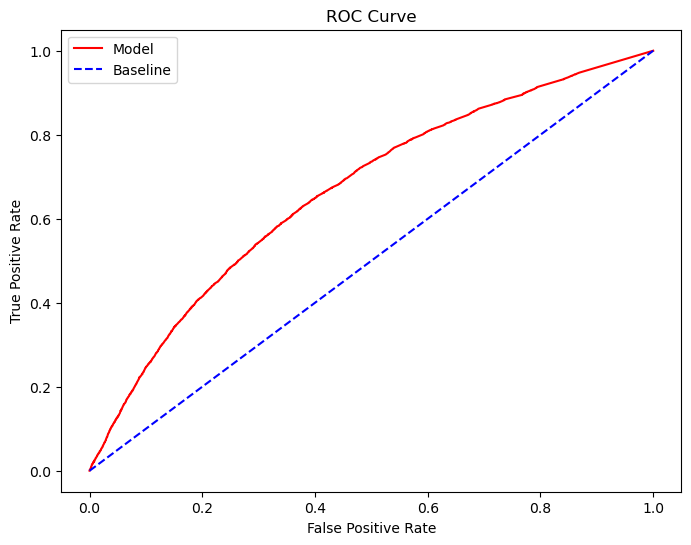

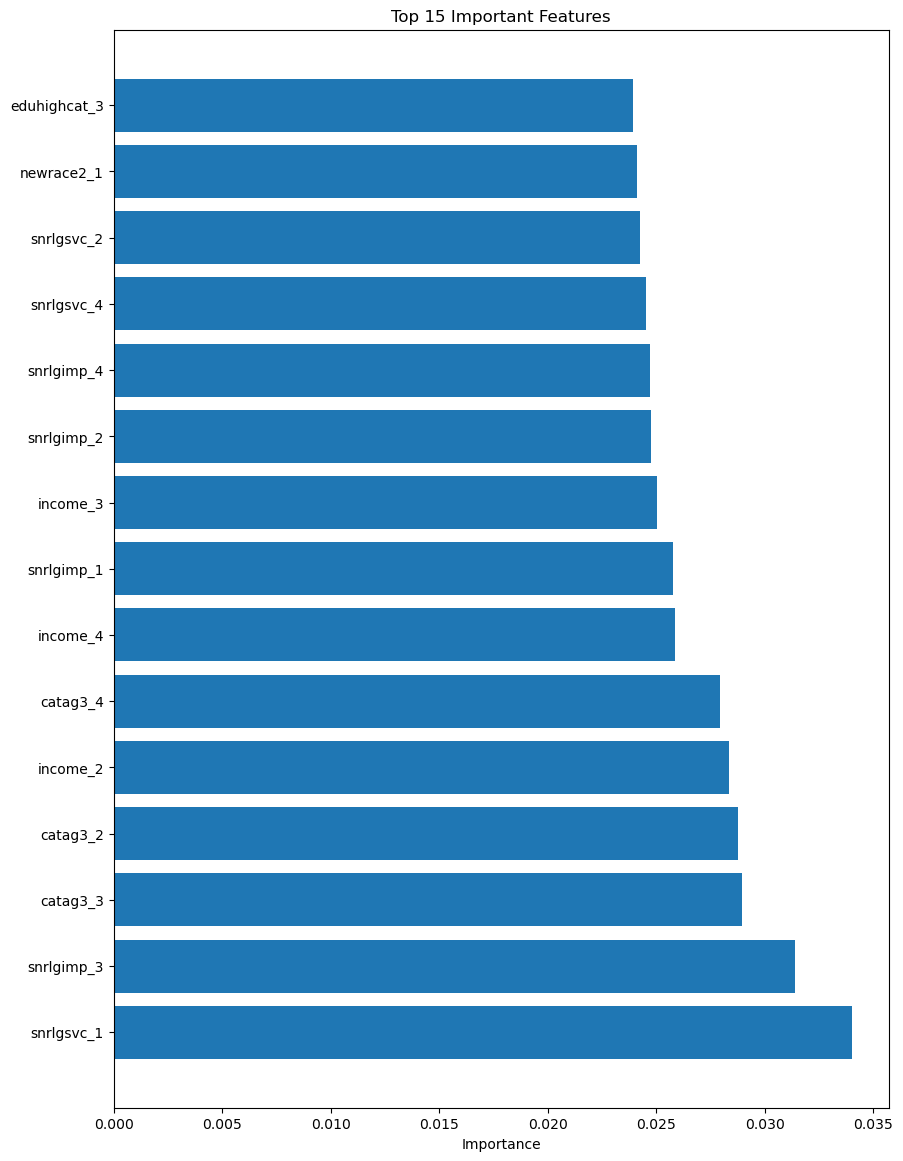


Final Model Performance:
Test Set Accuracy: 83.19%
Test Set ROC AUC: 0.665


In [23]:
pipeline, cv_scores, feature_importance = main(
    input_file=input_file,
    test_size=0.3,
    cv_folds=5
)